In [1]:
"""
Apply K-means to ericsson's ebm logs to find possible problems

In this example, SCC 755,796 might be related to DNS connection error.

Contact chao.x.xu@ericsson.com for detailed explanation

"""

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# learning input and parameters, try change following parameters
n_clusters  = 3
csvfilename = './Pembroke_csv/Pembroke_ef_l_tau.csv'

In [2]:
def read_l_tau_ef(file):
    # prepare the data
    # in csv, data format is
    # event_result, cause_code, sub_cause_code, tai
    # We're going to analysis the sub_cause_codes per tai to find if
    # there's some abnormal tai
    tais = {}
    scc_list = []
    with open(file) as fr:
        for line in fr.readlines():
            # both scc and tai are string
            [_, _, scc, tai] = line.strip().split(',')
            i_scc            = int(scc)
            tai_info         = tais.get(tai,{})
            old_scc_cnt      = tai_info.get(i_scc, 0)
            tai_info[i_scc]    = old_scc_cnt + 1
            tais[tai]        = tai_info
            scc_list.append(i_scc)     
    
    # remove same scc in list
    scc_list = list(set(scc_list))
    scc_list.sort()
    
    return tais,scc_list

In [3]:
def transform2nparray(tais, scclist):
    dataArr  = []
    labelArr = []
        
    for k,v in tais.items():        
        for scc in scclist:
            if v.get(scc) == None:
                v[scc] = 0                        
        labelArr += [[k]]
        # important, dataArr must be sorted in scc order
        dataArr  += [[v[i] for i in sorted(v.keys())]]
        
    return np.array(dataArr), np.array(labelArr)    

In [4]:
def probability(data):
    sumArr = np.sum(dataArr, axis=1, keepdims=True)
    return data / sumArr    

In [5]:
def droptai_with_less_event(tais, threshold=50):
    newtais = {}
    for tai,scc in tais.items():
        if sum(scc.values()) >= threshold:
            newtais[tai] = scc
        
    return newtais

In [6]:
# prepare data
tais,scc = read_l_tau_ef(csvfilename)
newtais  = droptai_with_less_event(tais) # less event means tai is good
dataArr, labelArr = transform2nparray(newtais, scc)
dataArr = probability(dataArr)

In [7]:
# K-means
clusters = {}
cluster_centers = {}
y_pred = KMeans(n_clusters=n_clusters).fit_predict(dataArr)

for i in range(n_clusters):
    clusters[i] = labelArr[y_pred == i]      
    cluster_centers[i] = np.mean(dataArr[y_pred == i], axis=0)

In [8]:
# plot pattern
fig = plt.figure()

for i in range(n_clusters):
    plt.plot(range(len(scc)), cluster_centers[i])
    
plt.xticks(range(len(scc)), scc)
plt.xlabel('sub_cause_code')
plt.ylabel('event count in 100%')
plt.legend(tuple(['Cluster'+str(i)+ ' ('\
                  + str(np.shape(clusters[i])[0]) + ' TAs)' for i in range(n_clusters)]), loc='best')
import os
plt.title('l_tau_ef scc percent from ' + os.path.basename(csvfilename))


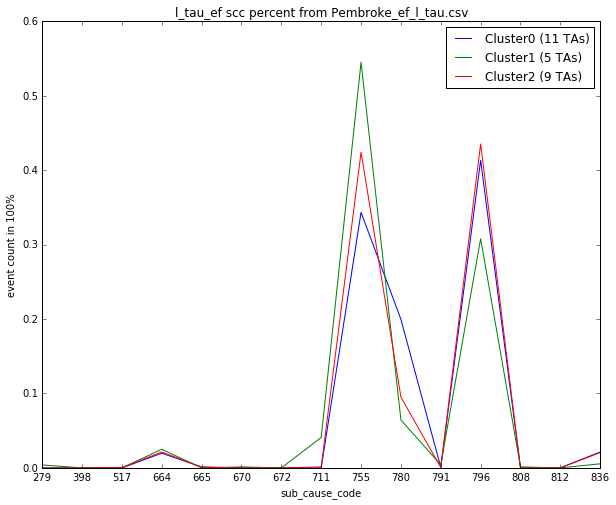

In [9]:
plt.show()